# H2O-CO2 EOS calculations
- DiadFit contains the EOS of Duan and Zhang (2006)
- This code was converted from the C code from  Yoshimura et al. (2023) - we thank them for making such a clear description of the mistakes in the original Duan and Zhang paper!
https://doi.org/10.2465/jmps.221224a
- There are two main types of calculations you might want to do with a mixed EOS. 
1) If you work on fluid inclusions, its nice to assume they are a pure CO$_2$ fluid. But in reality, you probably have some H$_2$O in the fluid phase. You can calculate a pressure for a given XH2O value, assuming the H has been lost .
1) If you are an experimentalist, you probably know P and T, and you have some idea of XH2O. You might want to calculate molar volumes, compressabilities, activities and fugacities. 

In [2]:
# If you havent already - install DiadFit. You need v.81+ to do these calcs.
#!pip install DiadFit --upgrade 

- If you havent installed CoolProp, you will need that package too
If you use conda, in your command line run:
conda install -c conda-forge coolprop

In [55]:
import DiadFit as pf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

## 1. Correcting fluid inclusions for H2O
- The theory for this is layed out in Hansteen and Klugel (2008). In all but the most anhydrous, deep systems, the exsolved fluid phase will contain some H2O. It is generally assumed that this is lost from the fluid inclusion, so you are left with CO2 you have measured by Raman spectroscopy
- First, you have to calculate the bulk density of the original CO2+H2O mix. Then, using this density, you can use the mixed EOS to calculate pressure. Here, we compare this to pure CO2 EOS. 
 - You can make 2 different end member assumptions - either all H is lost or the H exists as a film. The math is layed out below for these two examples
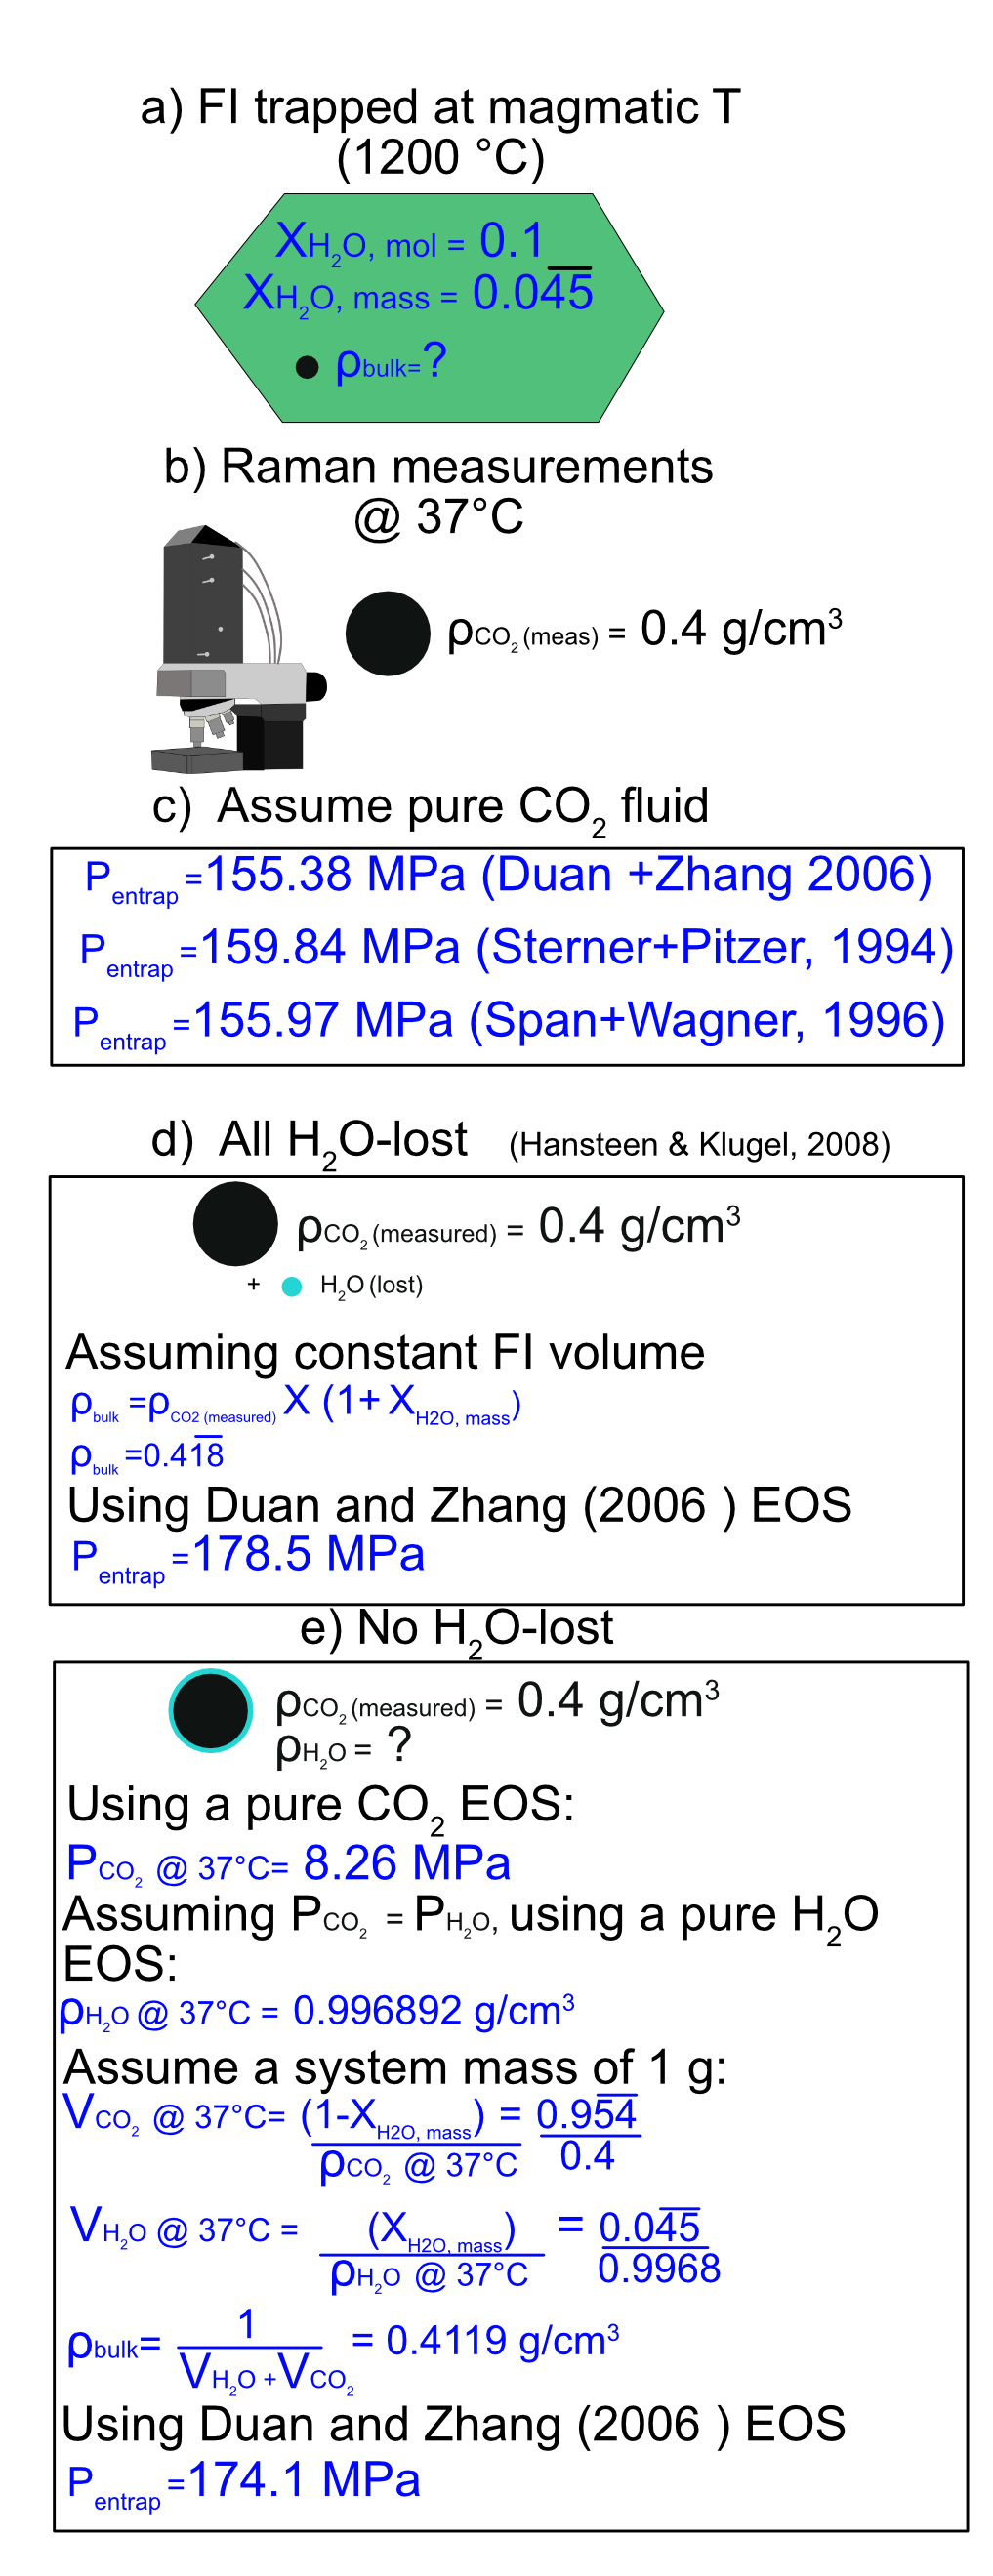

### 1a: Correcting a single FI composition
- Say you measured a CO2 density of 0.3, and you think XH2O=0.1 (perhaps based on melt inclusion data - you can get XH2O from VESical)
- Lets compare the calculations

In [56]:
Diff_EOS=pf.calculate_entrapment_P_XH2O(XH2O=0.1, CO2_dens_gcm3=0.3, T_K=1200+273.15, T_K_ambient=37+273.15 )
Diff_EOS

,P_kbar_pureCO2_SW96,P_kbar_pureCO2_SP94,P_kbar_pureCO2_DZ06,P_kbar_mixCO2_DZ06_Hloss,P_kbar_mixCO2_DZ06_no_Hloss,P Mix_Hloss/P Pure DZ06,P Mix_no_Hloss/P Pure DZ06,rho_mix_calc_Hloss,rho_mix_calc_noHloss,CO2_dens_gcm3,T_K,XH2O
0,1.055698,1.070557,1.052613,1.188251,1.169214,1.128859,1.110773,0.313636,0.309845,0.3,1473.15,0.1


- We can see that the mixed fluid pressure is ~13% higher than doing the pure calculation if H is lost, and 12% higher if H2O is in a film

### 1b - Visualizing changes across a wider space
- You dont have to feed a single value into this function, you could do an entire spreadsheet of values. 
- Here, lets do calculations for different densities for a range of XH2O values

In [57]:
XH2O=np.linspace(0, 0.2, 50) # 50 evenly spaced XH2O values

df_01=pf.calculate_entrapment_P_XH2O(XH2O=XH2O, CO2_dens_gcm3=0.1, T_K=1200+273.15)
df_02=pf.calculate_entrapment_P_XH2O(XH2O=XH2O, CO2_dens_gcm3=0.2, T_K=1200+273.15)
df_03=pf.calculate_entrapment_P_XH2O(XH2O=XH2O, CO2_dens_gcm3=0.3, T_K=1200+273.15)
df_05=pf.calculate_entrapment_P_XH2O(XH2O=XH2O, CO2_dens_gcm3=0.5, T_K=1200+273.15)
df_07=pf.calculate_entrapment_P_XH2O(XH2O=XH2O, CO2_dens_gcm3=0.7, T_K=1200+273.15)
df_09=pf.calculate_entrapment_P_XH2O(XH2O=XH2O, CO2_dens_gcm3=0.9, T_K=1200+273.15)
df_11=pf.calculate_entrapment_P_XH2O(XH2O=XH2O, CO2_dens_gcm3=1.1, T_K=1200+273.15)

# Create a dictionary to hold your density values and corresponding dataframe columns directly
densities = {
    0.1: df_01['P Mix_Hloss/P Pure DZ06'],
    0.2: df_02['P Mix_Hloss/P Pure DZ06'],
    0.3: df_03['P Mix_Hloss/P Pure DZ06'],
    0.5: df_05['P Mix_Hloss/P Pure DZ06'],
    0.7: df_07['P Mix_Hloss/P Pure DZ06'],
    0.9: df_09['P Mix_Hloss/P Pure DZ06'],
    1.1: df_11['P Mix_Hloss/P Pure DZ06'],
}

of course, you can write this in a loop if you want!

In [58]:
# Define CO2 densities to loop over
CO2_densities = [0.1, 0.2, 0.3, 0.5, 0.7, 0.9, 1.1]

# Initialize a dictionary to hold the dataframes
dfs = {}

# Loop over CO2 densities
for density in CO2_densities:
    # Calculate entrapment_P_XH2O for each CO2 density
    df = pf.calculate_entrapment_P_XH2O(XH2O=XH2O, CO2_dens_gcm3=density, T_K=1200 + 273.15)
    # Store the dataframe in the dictionary with a key indicating the CO2 density
    densities[density] = df['P Mix_Hloss/P Pure DZ06']

### Lets make a nice plot showing this

0.1
0.2
0.3
0.5
0.7
0.9
1.1


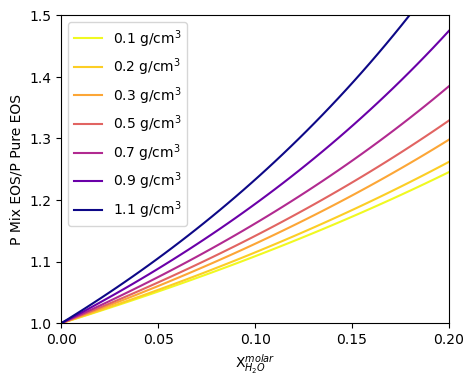

In [59]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Create figure and axes
fig, ax1 = plt.subplots(1, 1, figsize=(5, 4))

# Choose a colormap
cmap = plt.cm.plasma_r

# Create a Normalize object for your densities
norm = mcolors.Normalize(vmin=min(densities.keys()), vmax=max(densities.keys()))

# Create a ScalarMappable object with the normalization and colormap
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Plot each line on ax1 using the density as the key to retrieve the corresponding dataframe column
for density, data in densities.items():
    print(density)
    ax1.plot(XH2O, data, label=f'{density} g/cm$^3$', color=cmap(norm(density)))

ax1.legend()
ax1.set_xlabel('X$_{H_{2}O}^{molar}$')
ax1.set_ylabel('P Mix EOS/P Pure EOS')
#fig.colorbar(sm, ax=ax1, label='Density (g/cm$^3$)')
ax1.set_xticks([0, 0.05, 0.1, 0.15, 0.2])
ax1.set_xlim([0, 0.2])
ax1.set_ylim([1, 1.5])
plt.show()
fig.savefig('H2OCO2.png', dpi=200)


## 1c: Calculations on an entire spreadsheet
- Lets say to start with you want to apply a correction for a constant XH2O to all fluid inclusion densities

In [60]:
# Load in the excel spreadsheet
# Download it here - https://github.com/PennyWieser/DiadFit/blob/main/docs/Examples/EOS_calculations/FI_densities.xlsx
df=pd.read_excel('FI_densities.xlsx')
df.head()

,Sample,Density_g_cm3,Temp in C
0,FI1,0.1,1100
1,FI2,0.4,1200
2,FI3,0.7,1150
3,FI4,1.1,1200
4,FI5,1.5,1300


In [61]:
# Lets perform a calculation for 10 mol% H2O (A mol fraction of 0.1)
df_10perc=pf.calculate_entrapment_P_XH2O(XH2O=0.1, CO2_dens_gcm3=df['Density_g_cm3'], T_K=df['Temp in C'], T_K_ambient=37+273.15)
df_10perc

,P_kbar_pureCO2_SW96,P_kbar_pureCO2_SP94,P_kbar_pureCO2_DZ06,P_kbar_mixCO2_DZ06_Hloss,P_kbar_mixCO2_DZ06_no_Hloss,P Mix_Hloss/P Pure DZ06,P Mix_no_Hloss/P Pure DZ06,rho_mix_calc_Hloss,rho_mix_calc_noHloss,CO2_dens_gcm3,T_K,XH2O
0,0.218732,0.217395,0.218748,0.242265,0.241574,1.107509,1.104353,0.104545,0.104263,0.1,1100,0.1
1,1.230950,1.249353,1.227782,1.388440,1.354581,1.130852,1.103275,0.418182,0.411191,0.4,1200,0.1
2,2.965314,3.003832,2.981447,3.464521,3.258604,1.162027,1.092960,0.731818,0.709627,0.7,1150,0.1
3,8.841732,8.826510,9.107578,11.291880,9.736771,1.239833,1.069085,1.150000,1.096681,1.1,1200,0.1
4,23.436505,24.924885,29.177486,37.972866,30.395512,1.301444,1.041745,1.568182,1.482750,1.5,1300,0.1


## But this isnt realistic - we know that XH2O will vary as a function of pressure, getting higher for the shallower pressure inclusions. 
- if you have melt inclusions for your system, you could use saturation pressures calculated in VESical, which returns XH2O, to determine how XH2O varies as a function of pressure
- Here, we load in melt inclusion data from the 2018 eruption of Kilauea, where XH2O was calculated using MagmaSat

In [62]:
# Download excel file here! https://github.com/PennyWieser/DiadFit/blob/main/docs/Examples/EOS_calculations/FI_densities.xlsx
df_MI=pd.read_excel('FI_densities.xlsx', sheet_name='MI_data')
df_MI.head()

,Sat P (Bars),XCO2 (molar)
0,310,0.959107
1,360,0.963423
2,430,0.968782
3,970,0.986911
4,600,0.978391


- Lets see how XH2O varies with pressure

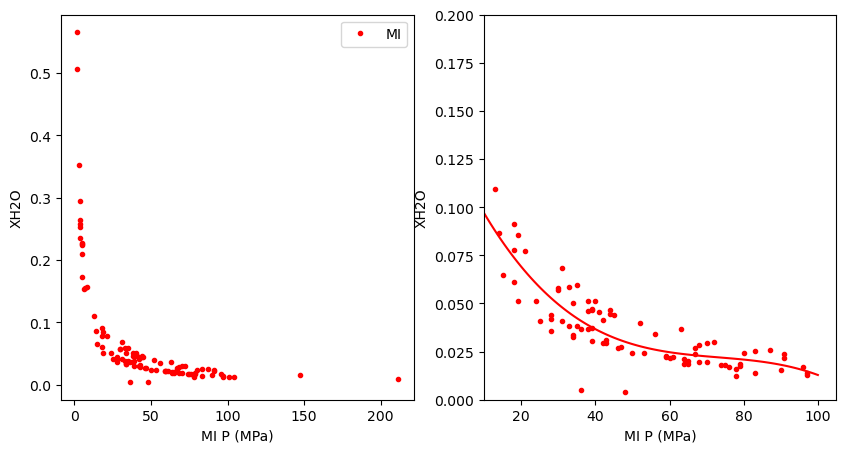

In [63]:
x=df_MI['Sat P (Bars)']/10
y=1-df_MI['XCO2 (molar)']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(x, y, '.r', label='MI')
# we only see FI with pressures of 20-100 MPa ish, 
filt=(x>10)& (x<100)
Pf = np.poly1d(np.polyfit(x[filt], y[filt],
                          3))
Px = np.linspace(10, 100, 101)
ax2.plot(x[filt], y[filt], '.r')
Py = Pf(Px)
ax2.plot(Px, Py, '-r')
ax2.set_ylim([0, 0.2])
ax2.set_xlim([10, 105])
ax1.set_ylabel('XH2O')
ax1.set_xlabel('MI P (MPa)')
ax2.set_ylabel('XH2O')
ax2.set_xlabel('MI P (MPa)')
ax1.legend()


- Now we need to loop - so initially use the polynomial to guess a XH2O for each MI, then re-evaluate after we get a new pressure for the FI accounting for H2O

In [64]:
# Load in FI data of DeVitre and Wieser (2024 - GPL) - https://github.com/PennyWieser/DiadFit/blob/main/docs/Examples/EOS_calculations/FI_densities.xlsx
df_FI=pd.read_excel('FI_densities.xlsx', sheet_name='FI_data')
df_FI.head()

,Density_g_cm3
0,0.176605
1,0.180578
2,0.180858
3,0.147317
4,0.102414


In [39]:
P_initial=pf.calculate_entrapment_P_XH2O(XH2O=0, CO2_dens_gcm3=df_FI['Density_g_cm3'], T_K=1200+273.15, T_K_ambient=37+273.15)
P=P_initial['P_kbar_mixCO2_DZ06_Hloss']*100
# Loop 10 times
for _ in range(10):
    XH2O_calc = Pf(P)
    Pressure_H_loss = pf.calculate_entrapment_P_XH2O(XH2O=XH2O_calc, CO2_dens_gcm3=df_FI['Density_g_cm3'], 
                                                     T_K=1200 + 273.15, T_K_ambient=37 + 273.15).P_kbar_mixCO2_DZ06_Hloss
    P = Pressure_H_loss * 100  # Update P for the next iteration
    # Optional: Print values to track changes in each iteration
    print(f"Iteration {_+1}: XH2O_calc = {XH2O_calc[0]}, Pressure_H_loss = {Pressure_H_loss[0]}")


Iteration 1: XH2O_calc = 0.02616125592104672, Pressure_H_loss = 0.5718466672145027
Iteration 2: XH2O_calc = 0.02559572821317145, Pressure_H_loss = 0.5715116454021261
Iteration 3: XH2O_calc = 0.025607668172389866, Pressure_H_loss = 0.5715187144592899
Iteration 4: XH2O_calc = 0.02560741594890774, Pressure_H_loss = 0.5715185651524117
Iteration 5: XH2O_calc = 0.02560742127603914, Pressure_H_loss = 0.5715185679400713
Iteration 6: XH2O_calc = 0.025607421176577994, Pressure_H_loss = 0.5715185679191079
Iteration 7: XH2O_calc = 0.025607421177325937, Pressure_H_loss = 0.5715185681273734
Iteration 8: XH2O_calc = 0.025607421169895186, Pressure_H_loss = 0.5715185679176993
Iteration 9: XH2O_calc = 0.025607421177376175, Pressure_H_loss = 0.571518568127384
Iteration 10: XH2O_calc = 0.025607421169894812, Pressure_H_loss = 0.5715185679176993


Text(0.5, 0, 'XH2O')

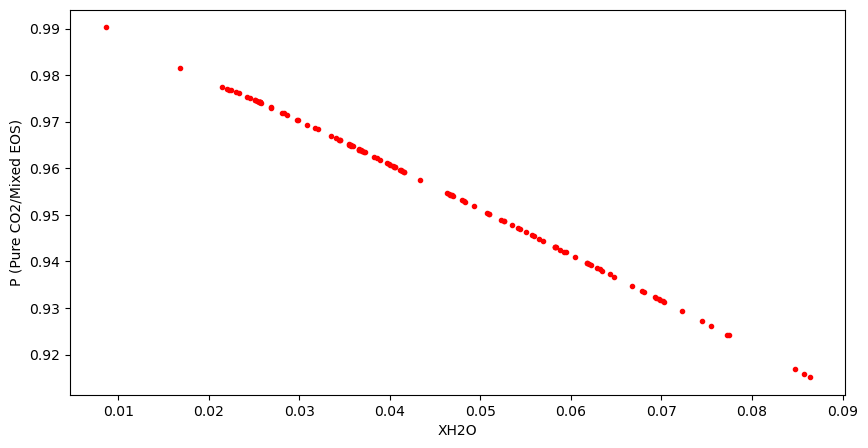

In [65]:
## Lets compare results as a function of pressure
fig, (ax2) = plt.subplots(1, 1, figsize=(10,5))


ax2.plot( XH2O_calc, P_initial['P_kbar_pureCO2_DZ06']*100/P, '.r')
ax2.set_ylabel('P (Pure CO2/Mixed EOS)')
ax2.set_xlabel('XH2O')
#ax1.plot([0, 100], [0, 100], '-k')

## 2. Calculations for experimentalists
- Download an example spreadsheet of experimental conditions
https://github.com/PennyWieser/DiadFit/blob/main/docs/Examples/EOS_calculations/Exp_Cond.xlsx

In [66]:
## Lets load in a spreadsheet of experimental conditions - Get from here: https://github.com/PennyWieser/DiadFit/blob/main/docs/Examples/EOS_calculations/Exp_Cond.xlsx
df_exp=pd.read_excel('Exp_Cond.xlsx')
df_exp.head()

,Experiment,P_kbar,XH2O,T_K
0,test1,1.0,0.1,1200
1,test2,2.0,0.2,1400
2,test3,4.0,0.0,800
3,test4,1.0,0.0,1500
4,test5,0.5,1.0,1200


In [67]:
df_calc=pf.calc_prop_knownP_EOS_DZ2006(P_kbar=df_exp['P_kbar'], T_K=df_exp['T_K'], XH2O=df_exp['XH2O'])
df_calc.head()


,P_kbar,T_K,XH2O,XCO2,Molar Volume (cm3/mol),Density (g/cm3),Compressability_factor,fugacity_H2O (kbar),fugacity_CO2 (kbar),activity_H2O,activity_CO2
0,1.0,1200,0.1,0.9,125.333500,0.330319,1.256179,0.092945,1.163275,0.100954,0.900294
1,2.0,1400,0.2,0.8,86.992117,0.446017,1.494677,0.424996,2.668323,0.213429,0.804635
2,4.0,800,0.0,1.0,45.153235,0.974460,2.715342,0.000000,17.198213,0.000000,1.000000
3,1.0,1500,0.0,1.0,155.085905,0.283714,1.243502,0.000000,1.264244,0.000000,1.000000
4,0.5,1200,1.0,0.0,191.178832,0.094153,0.958063,0.477024,0.000000,1.000000,0.000000


In [68]:
# You can also do the calc for a single condition!
df_calc2=pf.calc_prop_knownP_EOS_DZ2006(P_kbar=3, T_K=1400, XH2O=0.2)
df_calc2

,P_kbar,T_K,XH2O,XCO2,Molar Volume (cm3/mol),Density (g/cm3),Compressability_factor,fugacity_H2O (kbar),fugacity_CO2 (kbar),activity_H2O,activity_CO2
0,3,1400,0.2,0.8,67.007214,0.579042,1.726952,0.695761,5.283101,0.223567,0.806015
